# DeepGuard - Model Training Experiments

This notebook trains CNN models to detect AI-generated (fake) vs real images and logs experiments to MLflow/DagsHub.

**Task**: Binary Classification - Real (0) vs AI-Generated/Fake (1)  
**Models**: CNN architectures with varying depths and configurations

## 1. Setup & Dependencies

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# MLflow & DagsHub
import mlflow
import mlflow.keras
import dagshub

print(f"TensorFlow version: {tf.__version__}")


TensorFlow version: 2.17.0


## 2. DagsHub + MLflow Configuration

In [ ]:
# DagsHub MLflow Integration
DAGSHUB_USERNAME = "your-username"  # Replace with your DagsHub username
DAGSHUB_REPO_NAME = "DeepGuard-MLOps-Pipeline"
DAGSHUB_TOKEN = "your-token"  # Your DagsHub token

# Initialize DagsHub
dagshub.init(repo_owner=DAGSHUB_USERNAME, repo_name=DAGSHUB_REPO_NAME, mlflow=True)

# Set MLflow tracking URI
mlflow.set_tracking_uri(f"https://dagshub.com/{DAGSHUB_USERNAME}/{DAGSHUB_REPO_NAME}.mlflow")

# Set experiment
mlflow.set_experiment("DeepGuard-Model-Training")

print(f"MLflow Tracking URI: {mlflow.get_tracking_uri()}")

## 3. Load Preprocessed Data

In [5]:
# Load preprocessed data from notebook 01
PROCESSED_DIR = Path("../data/processed")

try:
    X_train = np.load(PROCESSED_DIR / "X_train_sample.npy")
    y_train = np.load(PROCESSED_DIR / "y_train_sample.npy")
    X_test = np.load(PROCESSED_DIR / "X_test_sample.npy")
    y_test = np.load(PROCESSED_DIR / "y_test_sample.npy")
    
    print(f"✅ Data loaded successfully!")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
except FileNotFoundError:
    print("❌ Preprocessed data not found!")
    print("Please run 01_data_exploration.ipynb first to create the preprocessed data.")
    X_train, y_train, X_test, y_test = None, None, None, None

✅ Data loaded successfully!
X_train: (1000, 128, 128, 3), y_train: (1000,)
X_test: (200, 128, 128, 3), y_test: (200,)


In [6]:
# Create validation split
if X_train is not None:
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

Training set: 800 samples
Validation set: 200 samples
Test set: 200 samples


## 4. Model Architectures

In [7]:
def build_simple_cnn(input_shape, name="SimpleCNN"):
    """
    Simple CNN architecture for baseline.
    """
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ], name=name)
    
    return model

def build_deeper_cnn(input_shape, name="DeeperCNN"):
    """
    Deeper CNN with more layers and regularization.
    """
    model = models.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ], name=name)
    
    return model

def build_efficientnet_style(input_shape, name="EfficientStyleCNN"):
    """
    EfficientNet-inspired architecture with depth-wise separable convolutions.
    """
    model = models.Sequential([
        # Stem
        layers.Conv2D(32, (3, 3), strides=2, padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Activation('swish'),
        
        # MBConv-style blocks
        layers.SeparableConv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('swish'),
        layers.MaxPooling2D((2, 2)),
        
        layers.SeparableConv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('swish'),
        layers.MaxPooling2D((2, 2)),
        
        layers.SeparableConv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('swish'),
        
        # Head
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='swish'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ], name=name)
    
    return model

print("Model architectures defined!")

Model architectures defined!


## 5. Training Function with MLflow Logging

In [8]:
def train_and_log_model(model, X_train, y_train, X_val, y_val, X_test, y_test,
                        epochs=20, batch_size=32, learning_rate=0.001,
                        run_name=None):
    """
    Train model and log everything to MLflow.
    """
    if run_name is None:
        run_name = model.name
    
    with mlflow.start_run(run_name=run_name):
        # Log parameters
        mlflow.log_param("model_name", model.name)
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("optimizer", "Adam")
        mlflow.log_param("input_shape", str(X_train.shape[1:]))
        mlflow.log_param("train_samples", X_train.shape[0])
        mlflow.log_param("val_samples", X_val.shape[0])
        mlflow.log_param("total_params", model.count_params())
        
        # Compile model
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy', keras.metrics.AUC(name='auc')]
        )
        
        # Callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ModelCheckpoint(
                f"../models/{model.name}_best.keras",
                monitor='val_auc',
                mode='max',
                save_best_only=True
            )
        ]
        
        # Train
        print(f"\n🚀 Training {model.name}...")
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )
        
        # Evaluate on test set
        test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=0)
        y_pred_proba = model.predict(X_test, verbose=0).flatten()
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        # Calculate additional metrics
        from sklearn.metrics import precision_score, recall_score, f1_score
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Log metrics
        mlflow.log_metric("test_loss", test_loss)
        mlflow.log_metric("test_accuracy", test_acc)
        mlflow.log_metric("test_auc", test_auc)
        mlflow.log_metric("test_precision", precision)
        mlflow.log_metric("test_recall", recall)
        mlflow.log_metric("test_f1", f1)
        mlflow.log_metric("best_val_loss", min(history.history['val_loss']))
        mlflow.log_metric("best_val_accuracy", max(history.history['val_accuracy']))
        
        # Log training history
        for epoch, (loss, acc, val_loss, val_acc) in enumerate(zip(
            history.history['loss'],
            history.history['accuracy'],
            history.history['val_loss'],
            history.history['val_accuracy']
        )):
            mlflow.log_metric("train_loss", loss, step=epoch)
            mlflow.log_metric("train_accuracy", acc, step=epoch)
            mlflow.log_metric("val_loss", val_loss, step=epoch)
            mlflow.log_metric("val_accuracy", val_acc, step=epoch)
        
        # Create and save confusion matrix
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                   xticklabels=['REAL', 'FAKE'], yticklabels=['REAL', 'FAKE'])
        axes[0].set_title(f"{model.name} - Confusion Matrix")
        axes[0].set_ylabel('True Label')
        axes[0].set_xlabel('Predicted Label')
        
        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        axes[1].plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC = {test_auc:.4f}')
        axes[1].plot([0, 1], [0, 1], 'r--', linewidth=1)
        axes[1].set_xlabel('False Positive Rate')
        axes[1].set_ylabel('True Positive Rate')
        axes[1].set_title(f"{model.name} - ROC Curve")
        axes[1].legend(loc='lower right')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        fig_path = f"../reports/figures/{model.name}_evaluation.png"
        plt.savefig(fig_path, dpi=150, bbox_inches='tight')
        mlflow.log_artifact(fig_path)
        plt.show()
        
        # Log model
        mlflow.keras.log_model(model, "model")
        
        # Print summary
        print(f"\n📊 {model.name} Results:")
        print(f"   Test Accuracy: {test_acc:.4f}")
        print(f"   Test AUC: {test_auc:.4f}")
        print(f"   Precision: {precision:.4f}")
        print(f"   Recall: {recall:.4f}")
        print(f"   F1 Score: {f1:.4f}")
        print(f"\n✅ Experiment logged to MLflow!")
        print(f"   Run ID: {mlflow.active_run().info.run_id}")
        
        return history, {
            'test_accuracy': test_acc,
            'test_auc': test_auc,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

## 6. Run Experiments

In [9]:
# Ensure models and figures directories exist
Path("../models").mkdir(parents=True, exist_ok=True)
Path("../reports/figures").mkdir(parents=True, exist_ok=True)

if X_train is not None:
    INPUT_SHAPE = X_train.shape[1:]  # (128, 128, 3)
    print(f"Input shape: {INPUT_SHAPE}")

Input shape: (128, 128, 3)


### Experiment 1: Simple CNN (Baseline)

Model: "SimpleCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,267,713 (12.47 MB)

 Trainable params: 3,267,713 (12.47 MB)

 Non-trainable params: 0 (0.00 B)


🚀 Training SimpleCNN...
Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 393ms/step - accuracy: 0.5387 - auc: 0.5475 - loss: 0.7295 - val_accuracy: 0.5950 - val_auc: 0.6905 - val_loss: 0.6426
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 407ms/step - accuracy: 0.5788 - auc: 0.6302 - loss: 0.6590 - val_accuracy: 0.6250 - val_auc: 0.7431 - val_loss: 0.6270
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 447ms/step - accuracy: 0.5775 - auc: 0.6277 - loss: 0.6528 - val_accuracy: 0.5800 - val_auc: 0.7473 - val_loss: 0.6362
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 376ms/step - accuracy: 0.6800 - auc: 0.7573 - loss: 0.6078 - val_accuracy: 0.6150 - val_auc: 0.7556 - val_loss: 0.6337
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 357ms/step - accuracy: 0.6700 - auc: 0.7271 - loss: 0.6086 - val_accuracy: 0.7200 - val_auc: 0.7810 - val_loss: 0.5665
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 369ms/step - accuracy: 0.7538 - auc: 0.8357 - loss: 0.5050 - val_accuracy: 0.6500 - val_auc: 0.7628 - val_loss: 0.6280
Epoch 7/15


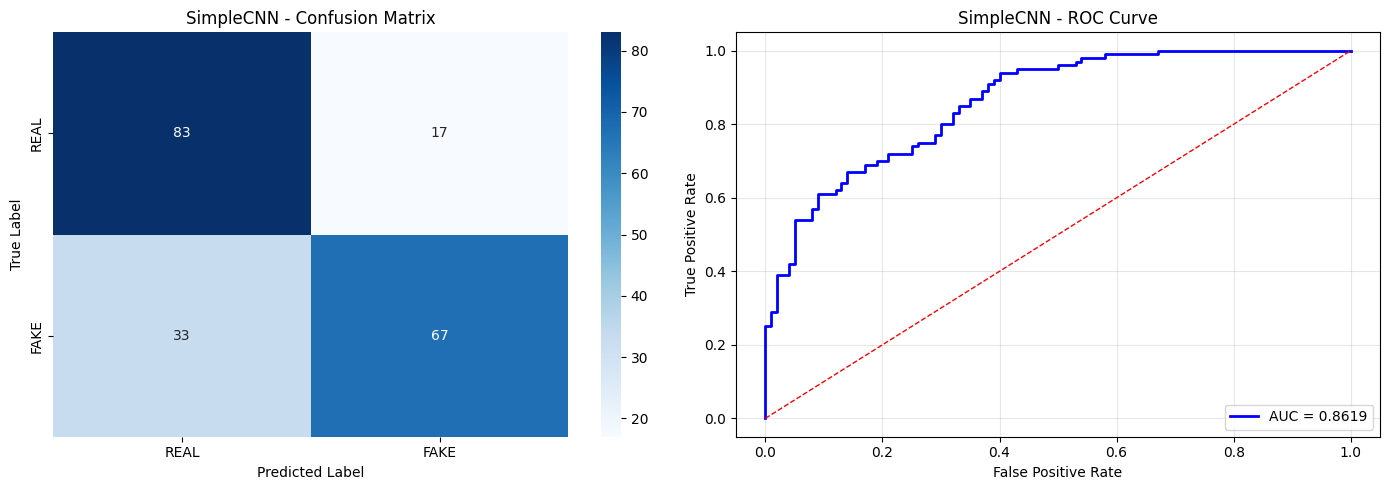

2025/12/13 15:11:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/13 15:12:03 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.



📊 SimpleCNN Results:
   Test Accuracy: 0.7500
   Test AUC: 0.8619
   Precision: 0.7976
   Recall: 0.6700
   F1 Score: 0.7283

✅ Experiment logged to MLflow!
   Run ID: f20a52ebb9234da4addeb17bb4c54084
🏃 View run SimpleCNN_baseline at: https://dagshub.com/pythonharsh1234/DeepGuard-MLOps-Pipeline.mlflow/#/experiments/1/runs/f20a52ebb9234da4addeb17bb4c54084
🧪 View experiment at: https://dagshub.com/pythonharsh1234/DeepGuard-MLOps-Pipeline.mlflow/#/experiments/1


In [10]:
if X_train is not None:
    model_simple = build_simple_cnn(INPUT_SHAPE)
    model_simple.summary()
    
    history_simple, results_simple = train_and_log_model(
        model_simple, X_train, y_train, X_val, y_val, X_test, y_test,
        epochs=15, batch_size=32, learning_rate=0.001,
        run_name="SimpleCNN_baseline"
    )

### Experiment 2: Deeper CNN

Model: "DeeperCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,678,049 (33.10 MB)

 Trainable params: 8,677,089 (33.10 MB)

 Non-trainable params: 960 (3.75 KB)


🚀 Training DeeperCNN...
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6425 - auc: 0.6724 - loss: 0.7737 - val_accuracy: 0.5000 - val_auc: 0.6563 - val_loss: 0.7272
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.6837 - auc: 0.7769 - loss: 0.5843 - val_accuracy: 0.5000 - val_auc: 0.6040 - val_loss: 0.8030
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7337 - auc: 0.8088 - loss: 0.5460 - val_accuracy: 0.5000 - val_auc: 0.6898 - val_loss: 0.8488
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7850 - auc: 0.8659 - loss: 0.4648 - val_accuracy: 0.5000 - val_auc: 0.6766 - val_loss: 0.8113
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8125 - auc: 0.8962 - loss: 0.4170 - val_accuracy: 0.5000 - val_auc: 0.5661 - val_loss: 0.7264
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8350 - auc: 0.9078 - loss: 0.3876 - val_accuracy: 0.5000 - val_auc: 0.6668 - val_loss: 0.7385
Epoch 7/20
25/25 ━━━━━━━━━━

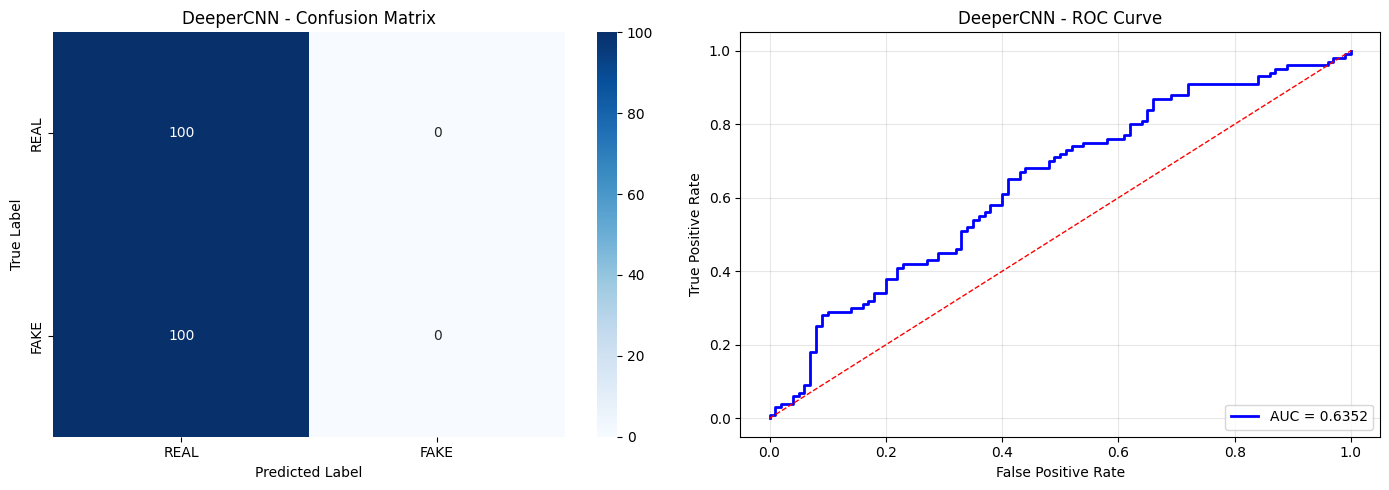

2025/12/13 15:19:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/13 15:19:19 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.



📊 DeeperCNN Results:
   Test Accuracy: 0.5000
   Test AUC: 0.6352
   Precision: 0.0000
   Recall: 0.0000
   F1 Score: 0.0000

✅ Experiment logged to MLflow!
   Run ID: 494d3567a55747539771f2f3b2ab2661
🏃 View run DeeperCNN_v1 at: https://dagshub.com/pythonharsh1234/DeepGuard-MLOps-Pipeline.mlflow/#/experiments/1/runs/494d3567a55747539771f2f3b2ab2661
🧪 View experiment at: https://dagshub.com/pythonharsh1234/DeepGuard-MLOps-Pipeline.mlflow/#/experiments/1


In [11]:
if X_train is not None:
    model_deeper = build_deeper_cnn(INPUT_SHAPE)
    model_deeper.summary()
    
    history_deeper, results_deeper = train_and_log_model(
        model_deeper, X_train, y_train, X_val, y_val, X_test, y_test,
        epochs=20, batch_size=32, learning_rate=0.001,
        run_name="DeeperCNN_v1"
    )

### Experiment 3: EfficientNet-Style CNN

Model: "EfficientStyleCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 64, 64, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 32, 32, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 16, 16, 256)    │        34,176 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,313 (317.63 KB)

 Trainable params: 80,353 (313.88 KB)

 Non-trainable params: 960 (3.75 KB)


🚀 Training EfficientStyleCNN...
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 328ms/step - accuracy: 0.6900 - auc: 0.7429 - loss: 0.6076 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 0.6934
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 358ms/step - accuracy: 0.7250 - auc: 0.8231 - loss: 0.5089 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 0.6955
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 296ms/step - accuracy: 0.7950 - auc: 0.8621 - loss: 0.4634 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 0.6992
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 282ms/step - accuracy: 0.8062 - auc: 0.8870 - loss: 0.4201 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 0.7041
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 264ms/step - accuracy: 0.8213 - auc: 0.9087 - loss: 0.3817 - val_accuracy: 0.5000 - val_auc: 0.4750 - val_loss: 0.7150
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - accuracy: 0.8213 - auc: 0.9090 - loss: 0.3844 - val_accuracy: 0.5000 - val_auc: 0.4750 - val_loss: 0.7171


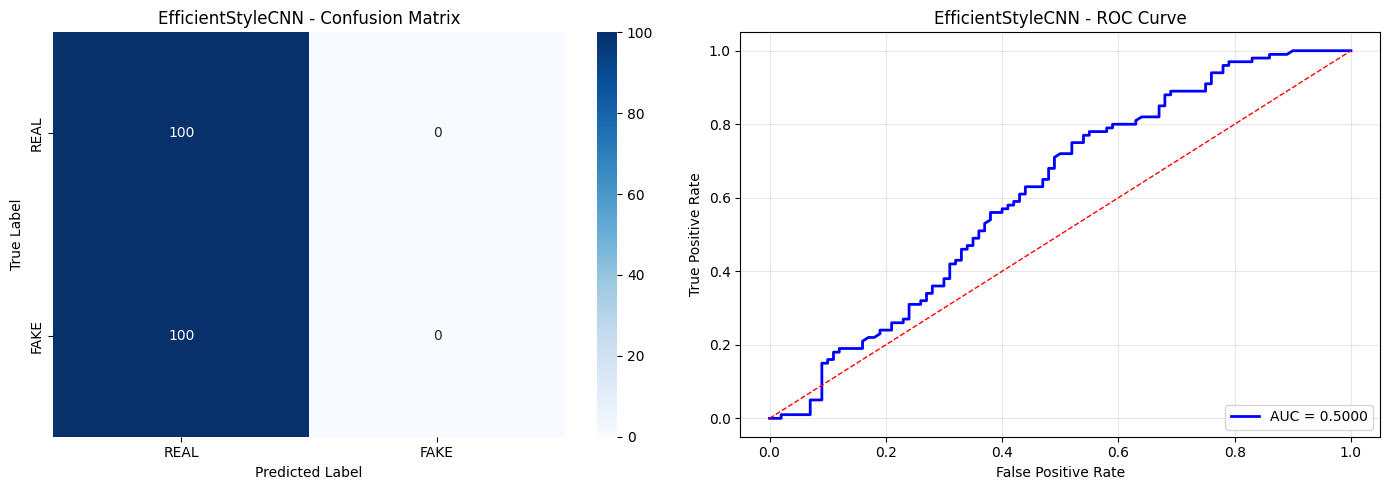

2025/12/13 15:22:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/13 15:22:56 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.



📊 EfficientStyleCNN Results:
   Test Accuracy: 0.5000
   Test AUC: 0.5000
   Precision: 0.0000
   Recall: 0.0000
   F1 Score: 0.0000

✅ Experiment logged to MLflow!
   Run ID: c3168827e7064f09ae074df47cb71dfd
🏃 View run EfficientStyleCNN_v1 at: https://dagshub.com/pythonharsh1234/DeepGuard-MLOps-Pipeline.mlflow/#/experiments/1/runs/c3168827e7064f09ae074df47cb71dfd
🧪 View experiment at: https://dagshub.com/pythonharsh1234/DeepGuard-MLOps-Pipeline.mlflow/#/experiments/1


In [12]:
if X_train is not None:
    model_efficient = build_efficientnet_style(INPUT_SHAPE)
    model_efficient.summary()
    
    history_efficient, results_efficient = train_and_log_model(
        model_efficient, X_train, y_train, X_val, y_val, X_test, y_test,
        epochs=20, batch_size=32, learning_rate=0.001,
        run_name="EfficientStyleCNN_v1"
    )

### Experiment 4: Hyperparameter Tuning (Learning Rate)


🚀 Training DeeperCNN_lr0.0001...
Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5750 - auc: 0.6264 - loss: 0.8648 - val_accuracy: 0.5000 - val_auc: 0.5946 - val_loss: 0.8009
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6850 - auc: 0.7521 - loss: 0.6704 - val_accuracy: 0.5000 - val_auc: 0.4742 - val_loss: 1.0465
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7038 - auc: 0.7649 - loss: 0.6195 - val_accuracy: 0.5000 - val_auc: 0.6305 - val_loss: 1.0629
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7837 - auc: 0.8359 - loss: 0.5246 - val_accuracy: 0.5000 - val_auc: 0.6646 - val_loss: 1.1263
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7900 - auc: 0.8671 - loss: 0.4645 - val_accuracy: 0.5000 - val_auc: 0.5386 - val_loss: 1.1284
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8062 - auc: 0.8859 - loss: 0.4348 - val_accuracy: 0.5000 - val_auc: 0.6383 - val_loss: 1.1615


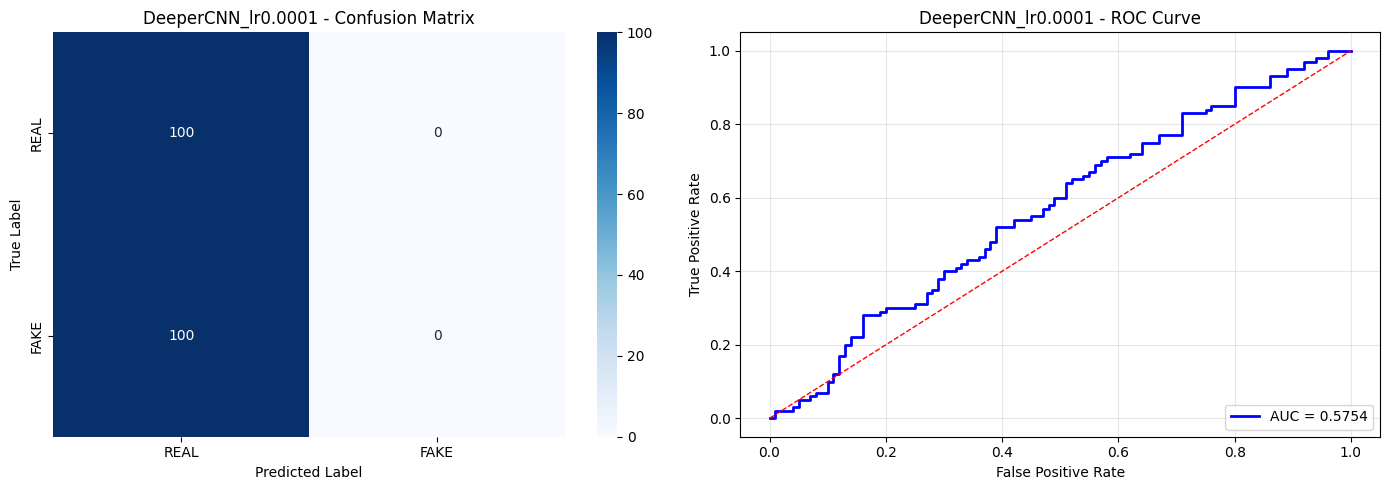

2025/12/13 15:26:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/13 15:26:57 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.



📊 DeeperCNN_lr0.0001 Results:
   Test Accuracy: 0.5000
   Test AUC: 0.5754
   Precision: 0.0000
   Recall: 0.0000
   F1 Score: 0.0000

✅ Experiment logged to MLflow!
   Run ID: 578fe8c9e12b48aca27ba11652a5820e
🏃 View run DeeperCNN_lr_0.0001 at: https://dagshub.com/pythonharsh1234/DeepGuard-MLOps-Pipeline.mlflow/#/experiments/1/runs/578fe8c9e12b48aca27ba11652a5820e
🧪 View experiment at: https://dagshub.com/pythonharsh1234/DeepGuard-MLOps-Pipeline.mlflow/#/experiments/1


🚀 Training DeeperCNN_lr0.0005...
Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6162 - auc: 0.6651 - loss: 0.7921 - val_accuracy: 0.5000 - val_auc: 0.3624 - val_loss: 0.7687
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7088 - auc: 0.7695 - loss: 0.6083 - val_accuracy: 0.5000 - val_auc: 0.3771 - val_loss: 0.7252
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7500 - auc: 0.8242 - loss: 0.5360 - val_accuracy: 0.5000 - val_auc: 0.5461 - val_loss: 0.6946
Epoch 4/15
25/25 

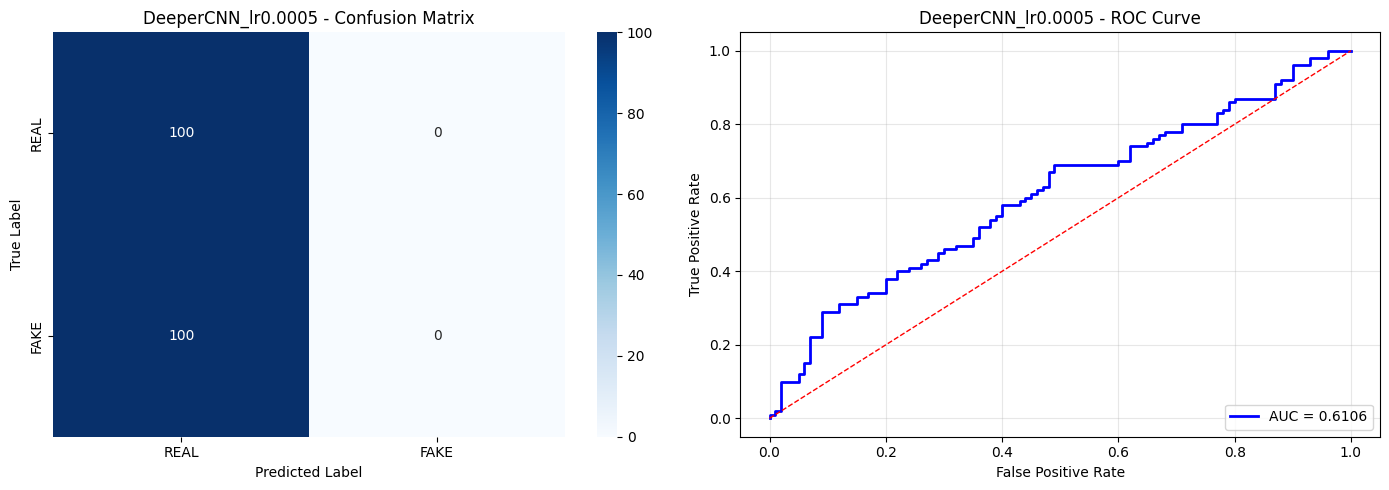

2025/12/13 15:35:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/13 15:35:46 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.



📊 DeeperCNN_lr0.0005 Results:
   Test Accuracy: 0.5000
   Test AUC: 0.6106
   Precision: 0.0000
   Recall: 0.0000
   F1 Score: 0.0000

✅ Experiment logged to MLflow!
   Run ID: e43247efc6344a3c802a3322700f3344
🏃 View run DeeperCNN_lr_0.0005 at: https://dagshub.com/pythonharsh1234/DeepGuard-MLOps-Pipeline.mlflow/#/experiments/1/runs/e43247efc6344a3c802a3322700f3344
🧪 View experiment at: https://dagshub.com/pythonharsh1234/DeepGuard-MLOps-Pipeline.mlflow/#/experiments/1

🚀 Training DeeperCNN_lr0.002...
Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5788 - auc: 0.6082 - loss: 0.8546 - val_accuracy: 0.4950 - val_auc: 0.4315 - val_loss: 0.8704
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6825 - auc: 0.7449 - loss: 0.6139 - val_accuracy: 0.5000 - val_auc: 0.3249 - val_loss: 0.8846
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7713 - auc: 0.8355 - loss: 0.5089 - val_accuracy: 0.5000 - val_auc: 0.3088 - val_loss: 0.9195
Epoch 4/15
25/25 ━━

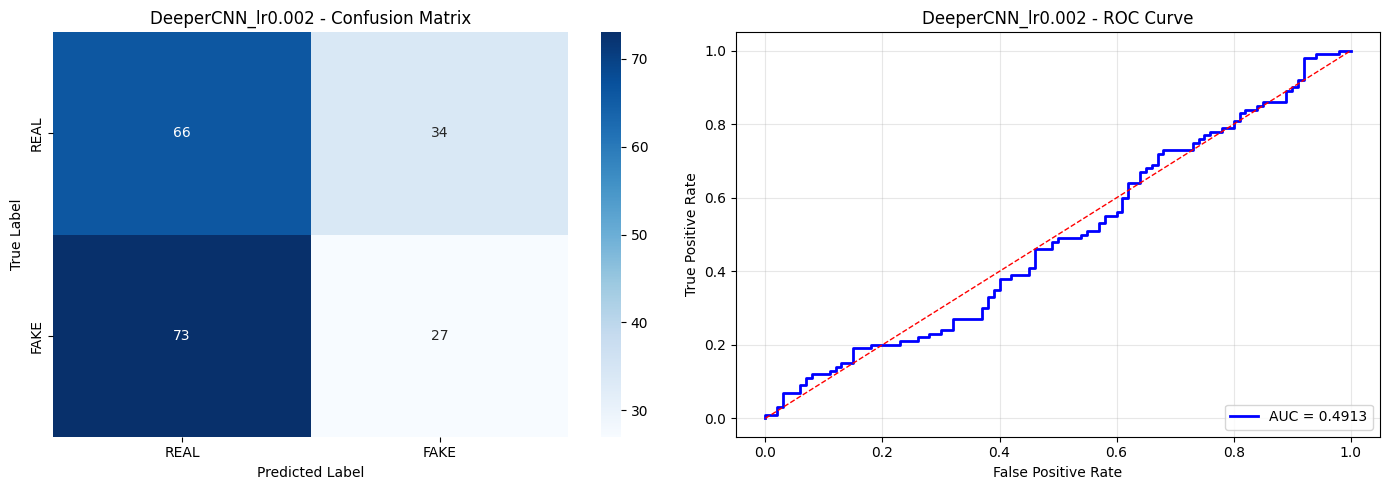

2025/12/13 15:44:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/13 15:45:06 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.



📊 DeeperCNN_lr0.002 Results:
   Test Accuracy: 0.4650
   Test AUC: 0.4913
   Precision: 0.4426
   Recall: 0.2700
   F1 Score: 0.3354

✅ Experiment logged to MLflow!
   Run ID: 21f9d519b1e8435b875b4e1df4b690b2
🏃 View run DeeperCNN_lr_0.002 at: https://dagshub.com/pythonharsh1234/DeepGuard-MLOps-Pipeline.mlflow/#/experiments/1/runs/21f9d519b1e8435b875b4e1df4b690b2
🧪 View experiment at: https://dagshub.com/pythonharsh1234/DeepGuard-MLOps-Pipeline.mlflow/#/experiments/1


In [13]:
if X_train is not None:
    # Test different learning rates with the best model
    learning_rates = [0.0001, 0.0005, 0.002]
    
    for lr in learning_rates:
        model = build_deeper_cnn(INPUT_SHAPE, name=f"DeeperCNN_lr{lr}")
        
        history, results = train_and_log_model(
            model, X_train, y_train, X_val, y_val, X_test, y_test,
            epochs=15, batch_size=32, learning_rate=lr,
            run_name=f"DeeperCNN_lr_{lr}"
        )
        
        # Clear session to free memory
        keras.backend.clear_session()

## 7. Compare Model Results

In [14]:
if X_train is not None:
    # Create comparison table
    results_df = pd.DataFrame([
        {'Model': 'SimpleCNN', **results_simple},
        {'Model': 'DeeperCNN', **results_deeper},
        {'Model': 'EfficientStyleCNN', **results_efficient},
    ])
    
    print("\n📊 Model Comparison:")
    print("=" * 80)
    print(results_df.to_string(index=False))
    
    # Find best model
    best_model = results_df.loc[results_df['test_auc'].idxmax(), 'Model']
    print(f"\n🏆 Best Model (by AUC): {best_model}")


📊 Model Comparison:
            Model  test_accuracy  test_auc  precision  recall       f1
        SimpleCNN           0.75   0.86190   0.797619    0.67 0.728261
        DeeperCNN           0.50   0.63515   0.000000    0.00 0.000000
EfficientStyleCNN           0.50   0.50000   0.000000    0.00 0.000000

🏆 Best Model (by AUC): SimpleCNN


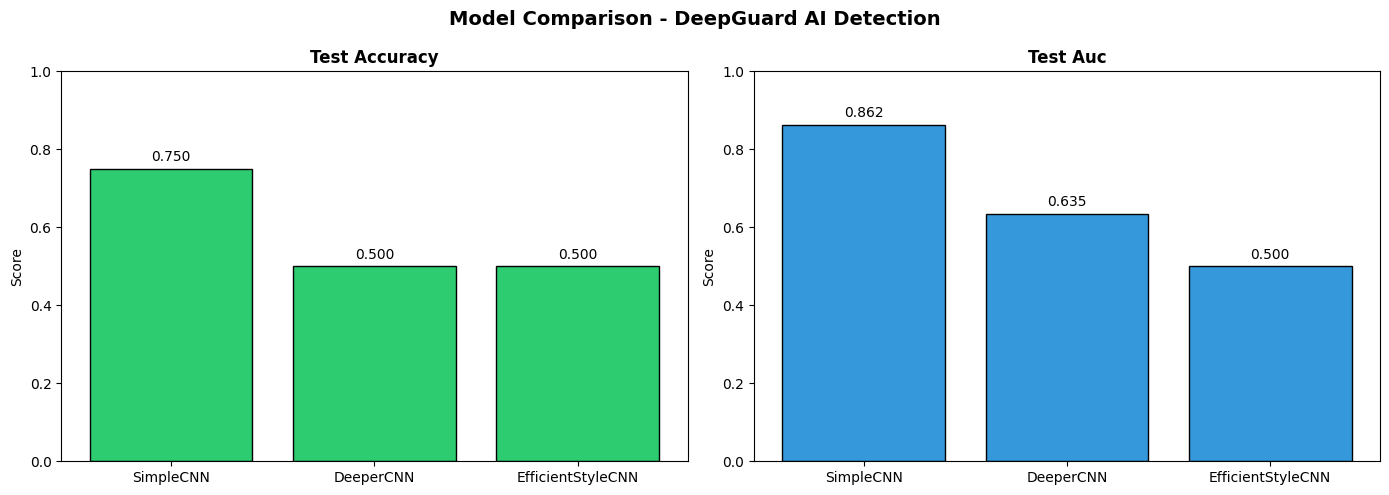

In [15]:
# Visualize comparison
if X_train is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    metrics = ['test_accuracy', 'test_auc']
    colors = ['#2ecc71', '#3498db']
    
    for ax, metric, color in zip(axes, metrics, colors):
        bars = ax.bar(results_df['Model'], results_df[metric], color=color, edgecolor='black')
        ax.set_title(metric.replace('_', ' ').title(), fontsize=12, fontweight='bold')
        ax.set_ylim(0, 1)
        ax.set_ylabel('Score')
        for bar, val in zip(bars, results_df[metric]):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                   f'{val:.3f}', ha='center', fontsize=10)
    
    plt.suptitle('Model Comparison - DeepGuard AI Detection', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('../reports/figures/model_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

## 8. Summary

In this notebook, I:
1. ✅ Built 3 CNN architectures (Simple, Deeper, EfficientNet-style)
2. ✅ Trained models with MLflow experiment tracking
3. ✅ Logged parameters, metrics, and artifacts to DagsHub
4. ✅ Compared model performance (Accuracy, AUC, F1)
5. ✅ Identified the best performing model

**Next Steps**:
- View experiments on DagsHub MLflow UI


In [16]:
print("\n🎉 All experiments completed!")
print(f"\nView your experiments at:")
print(f"https://dagshub.com/{DAGSHUB_USERNAME}/{DAGSHUB_REPO_NAME}.mlflow")


🎉 All experiments completed!

View your experiments at:
https://dagshub.com/pythonharsh1234/DeepGuard-MLOps-Pipeline.mlflow


In [24]:
import mlflow
import mlflow.keras
from tensorflow import keras

# Load the best saved model
model = keras.models.load_model("../models/DeeperCNN_best.keras")
print(f"✅ Loaded model: {model.name}")

# Log and register to MLflow
with mlflow.start_run(run_name="Register_DeeperCNN"):
    mlflow.keras.log_model(model, "model", registered_model_name="deepguard-detector")
    print(f"✅ Model logged and registered as 'deepguard-detector'")

# Verify
from mlflow.tracking import MlflowClient
client = MlflowClient()
versions = client.search_model_versions("name='deepguard-detector'")
print(f"\n📦 Registered versions: {len(versions)}")

✅ Loaded model: DeeperCNN


2025/12/13 16:02:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/13 16:02:34 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
Registered model 'deepguard-detector' already exists. Creating a new version of this model...
2025/12/13 16:04:30 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: deepguard-detector, version 1
Created version '1' of model 'deepguard-detector'.


✅ Model logged and registered as 'deepguard-detector'
🏃 View run Register_DeeperCNN at: https://dagshub.com/pythonharsh1234/DeepGuard-MLOps-Pipeline.mlflow/#/experiments/1/runs/dc5c320348e94684b17ff6db2ecfa0b7
🧪 View experiment at: https://dagshub.com/pythonharsh1234/DeepGuard-MLOps-Pipeline.mlflow/#/experiments/1

📦 Registered versions: 1
